In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field

In [2]:
model = ChatOllama(model='llama3.2')

model1 = ChatOllama(model='llama3.2')
model2 = ChatOllama(model='deepseek-r1')
model3 = ChatOllama(model="gemma3")

In [3]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model=model,
    tools=[],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [4]:
from langgraph.prebuilt import create_react_agent

def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model=model,
    tools=[add,multiply,divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [5]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [6]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (7a443670-c3c3-456d-93dd-1994edc061f4)
 Call ID: 7a443670-c3c3-456d-93dd-1994edc061f4
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

The result of the expression (3 + 5) * 7 is 56.




In [8]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=model,
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

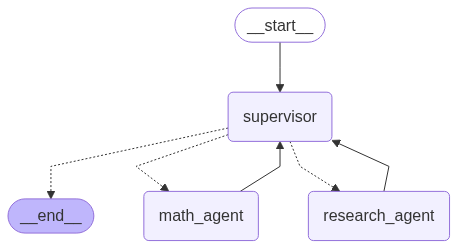

In [9]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [10]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

US and New York state GDP in 2024 are approximately $25.46 Trillion and $1.73 Trillion, respectively. The percentage of US GDP that New York State represents is approximately 6.8%.




In [11]:
class agentState(TypedDict):
    input_message: str

In [13]:
def input_node(state: agentState):
    input_text= "what's (3 + 5) x 7"
    return {'input_message':input_text}

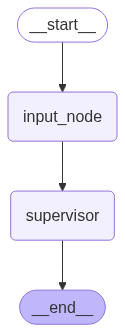

In [17]:
graph = StateGraph(agentState)

graph.add_node('input_node',input_node)
graph.add_node('supervisor',supervisor)
graph.add_edge(START,'input_node')
graph.add_edge('input_node','supervisor')
# graph.add_edge('supervisor',END)
workflow = graph.compile()
workflow